# import dependencies

In [107]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import random
import shutil

# https://stackoverflow.com/questions/72371859/attributeerror-module-collections-has-no-attribute-iterable
import collections

collections.Iterable = collections.abc.Iterable

# import the data

In [108]:
class ImageCSVDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None, test_set=False):
        """
        Args:
            image_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.

        """
        self.image_dir = image_dir
        self.labels = pd.read_csv(csv_file)
        self.transform = transform
        self.test_set = test_set

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.labels.iloc[idx]['filename']  # Assuming image name is in the first column
        image = Image.open(f"{self.image_dir}/{img_name}").convert('RGB')

        # https://stackoverflow.com/a/58200454
        # for data augmentation, it's "increasing" the size of the dataset by
        # randomly having a chance of applying augmentation to the image every epoch
        # each time the image is fetched, the result may be different by chance.
        if self.transform:
            image = self.transform(image)

        if self.test_set:
            return image

        label = self.labels.iloc[idx]['label']  # Assuming label is in the second column
        return image, label


# Define dataset and data loader.
image_dir = 'train/'
csv_file = 'train.csv'
image_dir_test = 'test/'
csv_file_test = 'test.csv'

# define data augmentations

In [109]:
# Define transformations (optional)
transform_mean = [0.5, 0.5, 0.5]
transform_std = [0.225, 0.225, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    
    # https://pytorch.org/vision/main/transforms.html#auto-augmentation
    # https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#augmentation-transforms
    # transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.RandAugment(),
    transforms.TrivialAugmentWide(),
    # transforms.AugMix(),
    
    # transforms.RandomResizedCrop((224, 224)),
    # transforms.RandomRotation(15),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=transform_mean,
                         std=transform_std)  # Normalize
])

# create data loaders

In [110]:
dataset = ImageCSVDataset(image_dir=image_dir, csv_file=csv_file, transform=transform)
original_dataset = ImageCSVDataset(image_dir=image_dir, csv_file=csv_file, transform=None)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
print(dataset_size, train_size, val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

8653 6922 1731


# visualizing transformations

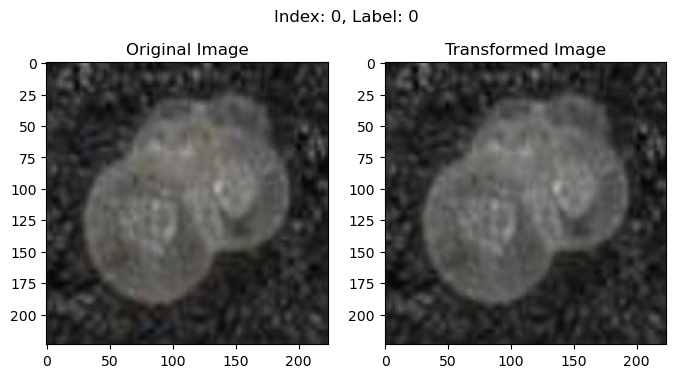

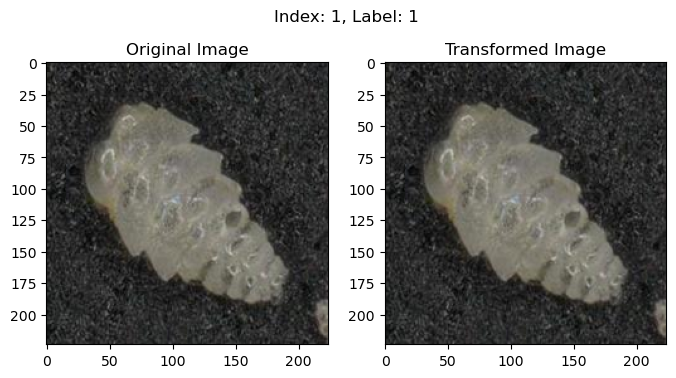

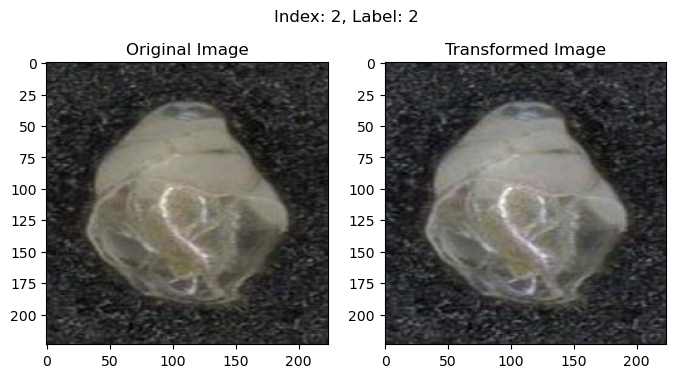

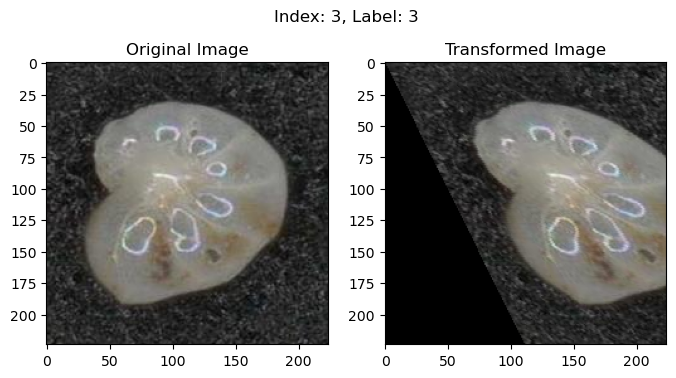

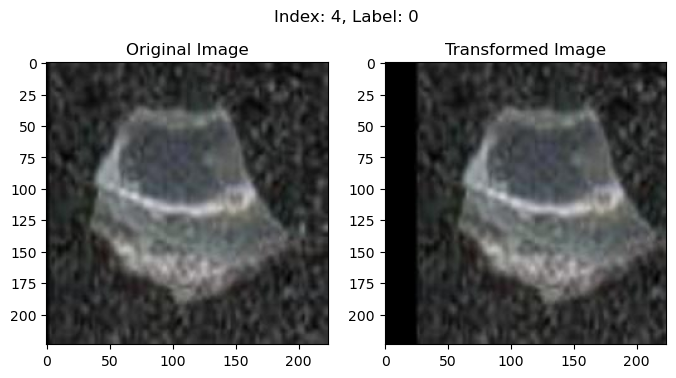

In [111]:
# Function to un-normalize and display images
def imshow(img, title, unnormalize=None):
    img = img.numpy().transpose((1, 2, 0))
    if unnormalize is not None:
        img = img * transform_std + transform_mean  # Un-normalize
    img = np.clip(img, 0, 1)  # Clip values to the range [0, 1] for display
    plt.imshow(img)
    plt.title(title)

# Visualize a few samples from the dataset
num_samples = 5
random_indices = random.sample(range(len(original_dataset)), num_samples)

for i in range(num_samples):
# for i in random_indices:
    original_image, label = original_dataset[i]  # Get the original image and label
    transformed_image, _ = dataset[i]  # Get the transformed image from the dataset with transformations
    
    # Display original and transformed images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    imshow(transforms.ToTensor()(original_image), title="Original Image")  # Display original image
    
    plt.subplot(1, 2, 2)
    imshow(transformed_image, title="Transformed Image", unnormalize=True)  # Display transformed image
    
    plt.suptitle(f"Index: {i}, Label: {label}")
    plt.show()

# fine tune pre-trained model

In [112]:
def validate(model, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_instances = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = sum(predictions == labels).item()
            total_correct += correct_predictions
            total_instances += len(inputs)
            
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    accuracy = round(total_correct / total_instances, 3)

    return avg_loss, accuracy

def train(model, criterion, optimizer, device):
    model.train() # set to train mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
            
def save_checkpoint(state, is_best, filename='./checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        

In [113]:
# Load a pre-trained model
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the final fully connected layer
num_classes = dataset.labels['label'].max() + 1
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Freeze early layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze later layers (optional)
for layer in list(model.children())[-3:]:  # Unfreeze last 3 layers
    for param in layer.parameters():
        param.requires_grad = True

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_acc1 = 0

for epoch in range(num_epochs):
    # train for one epoch
    train(model, criterion, optimizer, device)

    # evaluate on validation set
    val_loss, val_accuracy = validate(model, criterion, device)
    print(f'Epoch {epoch + 1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # adjust learning rate
    scheduler.step(val_loss)
    
    # remember best acc@1 and save checkpoint
    is_best = val_accuracy > best_acc1
    best_acc1 = max(val_accuracy, best_acc1)
    
    # set a checkpoint for best model
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
        'scheduler' : scheduler.state_dict()
    }, is_best)

[1, 100] loss: 1.318
[1, 200] loss: 0.897
Epoch 1: Validation Loss: 0.8035, Validation Accuracy: 0.7760
[2, 100] loss: 0.678
[2, 200] loss: 0.671
Epoch 2: Validation Loss: 0.6846, Validation Accuracy: 0.8020
[3, 100] loss: 0.553
[3, 200] loss: 0.528
Epoch 3: Validation Loss: 0.6802, Validation Accuracy: 0.8080
[4, 100] loss: 0.482
[4, 200] loss: 0.475
Epoch 4: Validation Loss: 0.6688, Validation Accuracy: 0.8160
[5, 100] loss: 0.413
[5, 200] loss: 0.406
Epoch 5: Validation Loss: 0.6858, Validation Accuracy: 0.8020
[6, 100] loss: 0.346
[6, 200] loss: 0.381
Epoch 6: Validation Loss: 0.6654, Validation Accuracy: 0.8190
[7, 100] loss: 0.276
[7, 200] loss: 0.323
Epoch 7: Validation Loss: 0.6509, Validation Accuracy: 0.8320
[8, 100] loss: 0.269
[8, 200] loss: 0.270
Epoch 8: Validation Loss: 0.7399, Validation Accuracy: 0.8200
[9, 100] loss: 0.266
[9, 200] loss: 0.263
Epoch 9: Validation Loss: 0.6891, Validation Accuracy: 0.8150
[10, 100] loss: 0.210
[10, 200] loss: 0.217
Epoch 10: Validation

# use best model to make predictions

In [114]:
def make_predictions():
    model = models.resnet50(weights=None)
    
    num_classes = dataset.labels['label'].max() + 1
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    checkpoint = torch.load("model_best.pth.tar", weights_only=True)
    model.load_state_dict(checkpoint['state_dict'])
    
    model.eval() # enter evaluation mode

    # Create test dataloader that doesn't have labels.
    dataset_test = ImageCSVDataset(image_dir=image_dir_test, csv_file=csv_file_test,
                                   transform=transform, test_set=True)
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    predictions = []
    with torch.no_grad():
        for i, data in enumerate(dataloader_test, 0):
            inputs = data.to(device)
            outputs = model(inputs)
            predictions.append(outputs.argmax(axis=1).detach().cpu().numpy())
    predictions = np.concatenate(predictions)
    
    # Write predictions to a submission file.
    df_predictions = pd.read_csv(csv_file_test)
    df_predictions['predictions'] = predictions
    df_predictions[['id', 'predictions']].to_csv('submission.csv', index=False)
    
    display(df_predictions)
    
make_predictions()

,id,filename,predictions
0,0,MV1012-BC-12_obj00007.jpg,1
1,1,MV1012-BC-12_obj00009.jpg,3
2,2,MV1012-BC-12_obj00011.jpg,1
3,3,MV1012-BC-12_obj00012.jpg,3
4,4,MV1012-BC-12_obj00013.jpg,5
...,...,...,...
2169,2169,MV1012-BC-8_obj01887.jpg,0
2170,2170,MV1012-BC-8_obj01892.jpg,0
2171,2171,MV1012-BC-8_obj01893.jpg,0
2172,2172,MV1012-BC-8_obj01899.jpg,1


# Resources Used
- https://github.com/pytorch/examples/blob/main/imagenet/main.py
- https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
- https://pytorch.org/vision/main/transforms.html
- https://www.kaggle.com/datasets/abhinavnayak/catsvdogs-transformed
- https://www.digitalocean.com/community/tutorials/training-validation-and-accuracy-in-pytorch